### Library Imports

In [10]:
import os  # Provides functions for interacting with the operating system.
import numpy as np  # Fundamental package for numerical computing.
import cv2  # OpenCV library for computer vision tasks.
from glob import glob  # Helps in finding all pathnames matching a specified pattern.
import tensorflow as tf  # TensorFlow deep learning framework.
from tensorflow.keras import backend as K  # Provides backend operations for Keras.
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping  # Callbacks for model training.
from tensorflow.keras.optimizers import Adam  # Adam optimizer for gradient descent.
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, SeparableConv2D,add, multiply  # Layers used in neural network architecture.
from tensorflow.keras.models import Model  # Model class from Keras for creating neural network models.
from sklearn.model_selection import train_test_split  # Splits data into training and validation sets.
from tensorflow.keras.models import load_model  # Loads pre-trained Keras models.
import pandas as pd  # Data manipulation library.
from tqdm import tqdm  # Progress bar library.
import matplotlib.pyplot as plt  # Plotting library for visualizations.


## Conv Block

In [2]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)  # Apply 3x3 convolution with 'num_filters' filters and padding
    x = BatchNormalization()(x)  # Normalize activations of the previous layer
    x = Activation("relu")(x)  # Apply ReLU activation function

    x = Conv2D(num_filters, 3, padding="same")(x)  # Apply another 3x3 convolution with 'num_filters' filters and padding
    x = BatchNormalization()(x)  # Normalize activations
    x = Activation("relu")(x)  # Apply ReLU activation

    return x


## Encoder Block

In [3]:
def encoder_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)  # Apply 3x3 convolution with 'num_filters' filters and padding
    x = BatchNormalization()(x)  # Normalize activations
    x = Activation("relu")(x)  # Apply ReLU activation
    return x

In [4]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    # p = MaxPool2D((2, 2))(x)
    return x

## Decoder Block

In [5]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)  # Perform transpose convolution to upsample features
    x = Concatenate()([x, skip_features])  # Concatenate upsampled features with skip connections from encoder
    return x

## Customized Attention with Residual Block

In [6]:
def Attention_block(x, g, F_init):
    g1 = Conv2D(filters=F_init, kernel_size=1, use_bias=True)(g)  # Transform g (skip connection) using 1x1 convolution
    g1 = BatchNormalization()(g1)  # Normalize activations
    print("Shape of g1:", g1.shape)

    x1 = Conv2D(filters=F_init, kernel_size=1, use_bias=True)(x)  # Transform x (main path) using 1x1 convolution
    x1 = BatchNormalization()(x1)  # Normalize activations
    print("Shape of x1:", x1.shape)

    gx = add([g1, x1])  # Element-wise addition of transformed g and x
    gx = Activation('relu')(gx)  # Apply ReLU activation
    print("Shape of gx:", gx.shape)

    psi = Conv2D(filters=F_init * 2, kernel_size=1, use_bias=True)(gx)  # Transform gx to compute attention weights
    psi = BatchNormalization()(psi)  # Normalize activations
    psi = Activation('sigmoid')(psi)  # Apply sigmoid activation to obtain attention coefficients
    print("Shape of psi:", psi.shape)

    out = multiply([x, psi])  # Multiply input x by computed attention coefficients
    print("Shape of out (attention):", out.shape)

    # Residual block
    res = Conv2D(filters=F_init * 2, kernel_size=3, padding='same', use_bias=True)(out)  # First 3x3 convolution
    res = BatchNormalization()(res)  # Normalize activations
    res = Activation('relu')(res)  # Apply ReLU activation
    print("Shape of res (first conv):", res.shape)

    res = Conv2D(filters=F_init * 2, kernel_size=3, padding='same', use_bias=True)(res)  # Second 3x3 convolution
    res = BatchNormalization()(res)  # Normalize activations
    print("Shape of res (second conv):", res.shape)

    out = add([out, res])  # Add residual connection to the attention-modulated output
    out = Activation('relu')(out)  # Apply ReLU activation to final output
    print("Shape of out (final):", out.shape)
    
    return out


## Up Convolution

In [7]:
def up_conv(inp, ch_out):
    x = UpSampling2D()(inp)  # Upsample input feature maps
    x = SeparableConv2D(filters=ch_out, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)  # Apply separable convolution
    x = BatchNormalization()(x)  # Normalize activations
    x = Activation('relu')(x)  # Apply ReLU activation
    
    return x

## Main Architecture

In [8]:
def DLU_Net(input_shape):
    inp = Input(input_shape)  # Define input layer
    x1 = encoder_block(inp, 64)  # First encoder block
    
    x2 = MaxPool2D()(x1)  # Downsampled by max pooling
    x2 = encoder_block(x2, 128)  # Second encoder block
    
    x3 = MaxPool2D()(x2)  # Downsampled by max pooling
    x3 = encoder_block(x3, 256)  # Third encoder block
    
    x4 = MaxPool2D()(x3)  # Downsampled by max pooling
    x4 = encoder_block(x4, 512)  # Fourth encoder block
    
    x5 = MaxPool2D()(x4)  # Downsampled by max pooling
    x5 = encoder_block(x5, 1024)  # Fifth encoder block
    
    # Decoding + Concatenation path
    
    d5 = up_conv(x5, 512)  # Upsample and apply convolutional block
    x4 = Attention_block(x=x4, g=d5, F_init=256)  # Apply attention mechanism between x4 and d5
    
    dcc5 = decoder_block(x5, x4, 512)  # Decode and concatenate x5 with x4
    d4 = up_conv(dcc5, 256)  # Upsample and apply convolutional block
    x3 = Attention_block(x=x3, g=d4, F_init=128)  # Apply attention mechanism between x3 and d4
    
    dcc4 = decoder_block(dcc5, x3, 256)  # Decode and concatenate dcc5 with x3
    
    d3 = up_conv(dcc4, 128)  # Upsample and apply convolutional block
    x2 = Attention_block(x=x2, g=d3, F_init=64)  # Apply attention mechanism between x2 and d3
    
    dcc3 = decoder_block(dcc4, x2, 128)  # Decode and concatenate dcc4 with x2
    
    d2 = up_conv(dcc3, 64)  # Upsample and apply convolutional block
    x1 = Attention_block(x=x1, g=d2, F_init=32)  # Apply attention mechanism between x1 and d2
    
    dcc3 = decoder_block(dcc3, x1, 64)  # Decode and concatenate dcc3 with x1
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d2)  # Final convolutional layer for segmentation
    
    model = Model(inp, outputs, name="DLU_NET")  # Define model with input and output
    return model

In [11]:
model = DLU_Net((256, 256, 3))  # Initialize DLU-Net model with input shape (256, 256, 3)
model.summary()  # Display model architecture summary

Shape of g1: (None, 32, 32, 256)
Shape of x1: (None, 32, 32, 256)
Shape of gx: (None, 32, 32, 256)
Shape of psi: (None, 32, 32, 512)
Shape of out (attention): (None, 32, 32, 512)
Shape of res (first conv): (None, 32, 32, 512)
Shape of res (second conv): (None, 32, 32, 512)
Shape of out (final): (None, 32, 32, 512)
Shape of g1: (None, 64, 64, 128)
Shape of x1: (None, 64, 64, 128)
Shape of gx: (None, 64, 64, 128)
Shape of psi: (None, 64, 64, 256)
Shape of out (attention): (None, 64, 64, 256)
Shape of res (first conv): (None, 64, 64, 256)
Shape of res (second conv): (None, 64, 64, 256)
Shape of out (final): (None, 64, 64, 256)
Shape of g1: (None, 128, 128, 64)
Shape of x1: (None, 128, 128, 64)
Shape of gx: (None, 128, 128, 64)
Shape of psi: (None, 128, 128, 128)
Shape of out (attention): (None, 128, 128, 128)
Shape of res (first conv): (None, 128, 128, 128)
Shape of res (second conv): (None, 128, 128, 128)
Shape of out (final): (None, 128, 128, 128)
Shape of g1: (None, 256, 256, 32)
Shape

# Dice Loss

In [16]:
smooth = 1e-15  # Smoothing factor to prevent division by zero

def dice_coef(y_true, y_pred):
    y_true_flat = tf.keras.layers.Flatten()(y_true)  # Flatten true labels
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)  # Flatten predicted labels

    if y_true_flat.shape != y_pred_flat.shape:
        raise ValueError("Shapes of y_true and y_pred do not match!")  # Ensure shape compatibility

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)  # Calculate intersection of true and predicted labels
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)  # Compute Dice coefficient

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)  # Define Dice loss as 1 minus Dice coefficient


# Train the model

In [17]:
H = 256  # Height of images
W = 256  # Width of images

def create_dir(path):
    if not os.path.exists(path):  # Check if directory exists
        os.makedirs(path)  # Create directory if it does not exist

create_dir("files")  # Example: Create directory named "files"


## Dataset Loading and Splitting Function

In [19]:
def load_dataset(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images", "*.png")))  # Retrieve and sort image paths
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))  # Retrieve and sort mask paths

    split_size = int(len(images) * split)  # Calculate split size based on percentage

    # Split dataset into train, validation, and test sets
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)
    
    # Further split train set into train and test sets
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


## Image and Mask Reading Functions for Preprocessing

In [20]:
def read_image(path):
    path = path.decode()  # Decode path from bytes to string
    x = cv2.imread(path, cv2.IMREAD_COLOR)  # Read image with OpenCV in color
    x = cv2.resize(x, (W, H))  # Resize image to specified height (H) and width (W)
    x = x / 255.0  # Normalize pixel values to [0, 1]
    x = x.astype(np.float32)  # Convert image to float32
    return x

def read_mask(path):
    path = path.decode()  # Decode path from bytes to string
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read mask image with OpenCV in grayscale
    x = cv2.resize(x, (W, H))  # Resize mask to specified height (H) and width (W)
    x = x / 255.0  # Normalize pixel values to [0, 1]
    x = x.astype(np.float32)  # Convert mask to float32
    x = np.expand_dims(x, axis=-1)  # Add channel dimension to mask
    return x


## TensorFlow Dataset Preparation Functions

In [21]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)  # Read and preprocess image
        y = read_mask(y)   # Read and preprocess mask
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])  # Use tf.numpy_function to apply _parse function to each element in X, Y
    x.set_shape([H, W, 3])  # Set shape of x to (H, W, 3)
    y.set_shape([H, W, 1])  # Set shape of y to (H, W, 1)
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))  # Create dataset from tensors X and Y
    dataset = dataset.map(tf_parse)  # Apply tf_parse function to preprocess each element in the dataset
    dataset = dataset.batch(batch)  # Batch the dataset with specified batch size
    dataset = dataset.prefetch(10)  # Prefetch data for efficiency
    return dataset


## Hyperparameters

In [22]:
batch_size = 6  # Batch size for training
lr = 1e-4  # Learning rate
num_epochs = 300  # Number of training epochs
model_path = os.path.join("files", "model.h5")  # Path to save trained model
csv_path = os.path.join("files", "log.csv")  # Path to save training logs

dataset_path = r"C:\Dataset_1\Aug_8"  # Path to your dataset directory


## Load and Print Dataset Splits

In [23]:
import os
from glob import glob

# Load dataset splits (train, validation, test)
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

# Print the number of samples in each split
print(f"Train: ({len(train_x)}, {len(train_y)})")
print(f"Valid: ({len(valid_x)}, {len(valid_y)})")
print(f"Test: ({len(test_x)}, {len(test_y)})")


Train: (19610,19610)
Valid: (2451,2451)
Test: (2451,2451)


In [24]:
# Prepare the training dataset using the tf_dataset function
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)

# Prepare the validation dataset using the tf_dataset function
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [25]:
# Initialize the model with input shape (H, W, 3)
model = DLU_Net((H, W, 3))

# Compile the model with dice loss, Adam optimizer, and metrics including dice coefficient and accuracy
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, 'accuracy'])

Shape of g1: (None, 32, 32, 256)
Shape of x1: (None, 32, 32, 256)
Shape of gx: (None, 32, 32, 256)
Shape of psi: (None, 32, 32, 512)
Shape of out (attention): (None, 32, 32, 512)
Shape of res (first conv): (None, 32, 32, 512)
Shape of res (second conv): (None, 32, 32, 512)
Shape of out (final): (None, 32, 32, 512)
Shape of g1: (None, 64, 64, 128)
Shape of x1: (None, 64, 64, 128)
Shape of gx: (None, 64, 64, 128)
Shape of psi: (None, 64, 64, 256)
Shape of out (attention): (None, 64, 64, 256)
Shape of res (first conv): (None, 64, 64, 256)
Shape of res (second conv): (None, 64, 64, 256)
Shape of out (final): (None, 64, 64, 256)
Shape of g1: (None, 128, 128, 64)
Shape of x1: (None, 128, 128, 64)
Shape of gx: (None, 128, 128, 64)
Shape of psi: (None, 128, 128, 128)
Shape of out (attention): (None, 128, 128, 128)
Shape of res (first conv): (None, 128, 128, 128)
Shape of res (second conv): (None, 128, 128, 128)
Shape of out (final): (None, 128, 128, 128)
Shape of g1: (None, 256, 256, 32)
Shape

In [26]:
# Define a list of callbacks to be used during model training
callbacks = [
    # Save the best model based on validation loss
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),

    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),

    # Log training process to a CSV file
    CSVLogger(csv_path),

    # Stop training when a monitored metric has stopped improving
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]


## Dice Coefficient

In [27]:
# Define the smoothing constant to avoid division by zero
smooth = 1e-15

def dice_coef(y_true, y_pred):
    # Print the shape of y_true
    print("Shape of y_true:", tf.shape(y_true))
    # Print the shape of y_pred
    print("Shape of y_pred:", tf.shape(y_pred))

    # Flatten y_true and y_pred
    y_true_flat = tf.keras.layers.Flatten()(y_true)
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)

    # Print the shape of flattened y_true
    print("Shape of y_true_flat:", tf.shape(y_true_flat))
    # Print the shape of flattened y_pred
    print("Shape of y_pred_flat:", tf.shape(y_pred_flat))

    # Check if the shapes of y_true_flat and y_pred_flat are the same
    if y_true_flat.shape != y_pred_flat.shape:
        raise ValueError("Shapes of y_true and y_pred do not match!")

    # Calculate the intersection between y_true_flat and y_pred_flat
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    # Calculate the Dice coefficient
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)


In [28]:
# Train the model using the training dataset and validate with the validation dataset
model.fit(
    train_dataset,      # Training dataset
    epochs=num_epochs,  # Number of epochs to train
    validation_data=valid_dataset,  # Validation dataset
    callbacks=callbacks,  # List of callbacks to apply during training
    verbose=1,  # Verbosity mode (1 for progress bar)
)


Epoch 1/300
Shape of y_true: Tensor("dice_loss/Shape:0", shape=(4,), dtype=int32)
Shape of y_pred: Tensor("dice_loss/Shape_1:0", shape=(4,), dtype=int32)
Shape of y_true_flat: Tensor("dice_loss/Shape_2:0", shape=(2,), dtype=int32)
Shape of y_pred_flat: Tensor("dice_loss/Shape_3:0", shape=(2,), dtype=int32)
Shape of y_true: Tensor("dice_loss/Shape:0", shape=(4,), dtype=int32)
Shape of y_pred: Tensor("dice_loss/Shape_1:0", shape=(4,), dtype=int32)
Shape of y_true_flat: Tensor("dice_loss/Shape_2:0", shape=(2,), dtype=int32)
Shape of y_pred_flat: Tensor("dice_loss/Shape_3:0", shape=(2,), dtype=int32)
3269/3269 [==============================] - ETA: 0s - loss: 0.4638 - dice_coef: 0.5363 - accuracy: 0.9769Shape of y_true: Tensor("dice_loss/Shape:0", shape=(4,), dtype=int32)
Shape of y_pred: Tensor("dice_loss/Shape_1:0", shape=(4,), dtype=int32)
Shape of y_true_flat: Tensor("dice_loss/Shape_2:0", shape=(2,), dtype=int32)
Shape of y_pred_flat: Tensor("dice_loss/Shape_3:0", shape=(2,), dtype=i

KeyboardInterrupt: 

`   `   `   `   `   `   `   `   `   `   `   `   `   `   `   `   `   `   `   `   `   ## Learnig curves

## Training Metrices

In [29]:
import pandas as pd
metrics = pd.read_csv(r"C:\Brats\files\log.csv")
metrics.head(20)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.976853,0.536251,0.463752,0.0001,0.985866,0.438561,0.561223
1,1,0.990757,0.749483,0.250489,0.0001,0.989803,0.681374,0.318211
2,2,0.991968,0.789137,0.210855,0.0001,0.991459,0.770811,0.228881
3,3,0.992664,0.812909,0.187110,0.0001,0.990991,0.760391,0.239750
4,4,0.993311,0.833964,0.166053,0.0001,0.991444,0.784522,0.215584
5,5,0.993645,0.844403,0.155610,0.0001,0.992069,0.794926,0.205147
6,6,0.993977,0.855766,0.144245,0.0001,0.992786,0.820471,0.179490
7,7,0.994378,0.868772,0.131241,0.0001,0.994286,0.861631,0.138356
8,8,0.994629,0.876286,0.123724,0.0001,0.994114,0.863817,0.136231
9,9,0.994940,0.886497,0.113514,0.0001,0.992997,0.811143,0.188791


In [30]:
mean_accuracy = metrics['accuracy'].mean()
mean_val_accuracy = metrics['val_accuracy'].mean()

print(f"Overall Training Accuracy: {mean_accuracy:.5f}")
print(f"Overall Validation Accuracy: {mean_val_accuracy:.5f}")

Overall Training Accuracy: 0.99706
Overall Validation Accuracy: 0.99668


# Dice_coef

<Axes: >

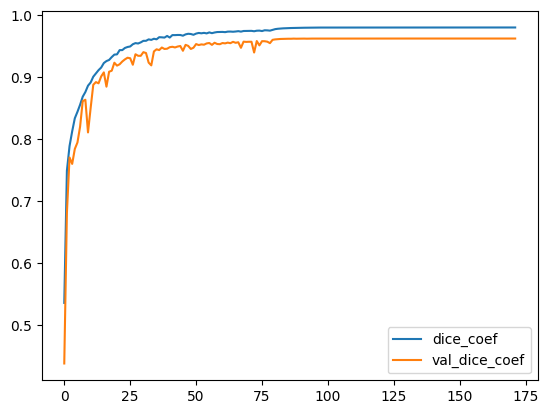

In [31]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

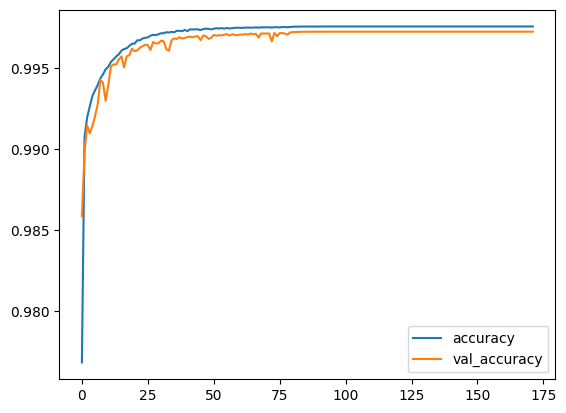

In [32]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

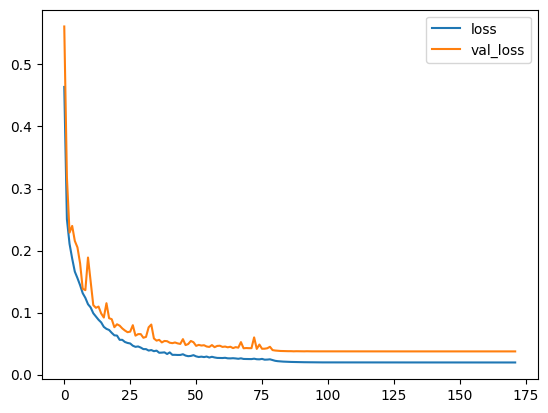

In [33]:
metrics[['loss','val_loss']].plot()

## Load the model

In [ ]:
model = load_model(r"C:\Augmented DAtaset\files\model.h5", custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

print("Model loaded successfully.")

## Saving Prediction Results

In [35]:
from tqdm import tqdm

def save_results(image, mask, y_pred, save_image_path):
    # Expand the mask to have 3 channels
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    # Expand the prediction to have 3 channels and scale it
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    # Create a separator line for visualization
    line = np.ones((H, 10, 3)) * 255

    # Concatenate the original image, mask, and prediction for comparison
    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)

    # Save the concatenated image to the specified path
    cv2.imwrite(save_image_path, cat_images)


In [36]:
# Create the "results" folder if it doesn't exist
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


## Testing the Model

In [37]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import f1_score, jaccard_score, recall_score, precision_score, accuracy_score, confusion_matrix

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = os.path.basename(x)

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image / 255.0                       ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask / 255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    accuracy_value = accuracy_score(mask, y_pred)
    dice_value = dice_coefficient(mask, y_pred)
    specificity_value = specificity_score(mask, y_pred)
    sensitivity_value = sensitivity_score(mask, y_pred)
    iou_value = mean_iou(mask, y_pred)

    SCORE.append([name, f1_value, jac_value, recall_value, precision_value, accuracy_value, dice_value, specificity_value, sensitivity_value, iou_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall (Sensitivity): {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")
print(f"Accuracy: {score[4]:0.5f}")
print(f"Dice Coefficient: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")
print(f"Sensitivity: {score[7]:0.5f}")
print(f"Mean IoU: {score[8]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision", "Accuracy", "Dice Coefficient", "Specificity", "Sensitivity", "Mean IoU"])
df.to_csv("files/score.csv", index=None)


100%|██████████| 2451/2451 [05:10<00:00,  7.89it/s]

F1: 0.92461
Jaccard: 0.87918
Recall (Sensitivity): 0.92190
Precision: 0.93602
Accuracy: 0.99822
Dice Coefficient: 0.92461
Specificity: 0.99930
Sensitivity: 0.92190
Mean IoU: 0.87918


## with Confusion MAtrix

Train: (9806,9806)
Valid: (1225,1225)
Test: (1225,1225)


100%|██████████| 1225/1225 [02:51<00:00,  7.14it/s]


F1: 0.90693
Jaccard: 0.85593
Recall (Sensitivity): 0.90325
Precision: 0.92381
Accuracy: 0.99776
Dice Coefficient: 0.90693
Specificity: 0.99913
Sensitivity: 0.90325
Mean IoU: 0.85593


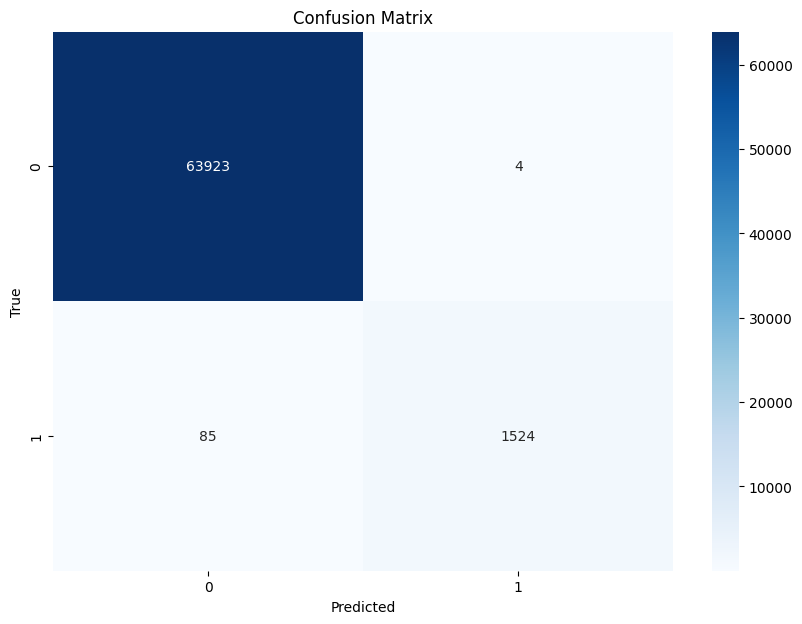

In [42]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

def mean_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

def save_results(image, mask, y_pred, path):
    # Assuming this function saves the results correctly
    pass

# Assuming load_dataset is defined and works correctly
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

SCORE = []
y_true_all = []
y_pred_all = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image / 255.0                       ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask / 255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Collecting all true and predicted values """
    y_true_all.extend(mask)
    y_pred_all.extend(y_pred)

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    accuracy_value = accuracy_score(mask, y_pred)
    dice_value = dice_coefficient(mask, y_pred)
    specificity_value = specificity_score(mask, y_pred)
    sensitivity_value = sensitivity_score(mask, y_pred)
    iou_value = mean_iou(mask, y_pred)

    SCORE.append([name, f1_value, jac_value, recall_value, precision_value, accuracy_value, dice_value, specificity_value, sensitivity_value, iou_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall (Sensitivity): {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")
print(f"Accuracy: {score[4]:0.5f}")
print(f"Dice Coefficient: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")
print(f"Sensitivity: {score[7]:0.5f}")
print(f"Mean IoU: {score[8]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision", "Accuracy", "Dice Coefficient", "Specificity", "Sensitivity", "Mean IoU"])
df.to_csv("files/score.csv", index=None)

# Compute the confusion matrix
cm = confusion_matrix(mask, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [100]:
scores = pd.read_csv(r"C:\Augmented DAtaset\files\score.csv")
scores.head(20)

,Image,F1,Jaccard,Recall,Precision
0,C:\Dataset_1\with_Aug_2\Aug\images\1880.png,0.902778,0.822785,0.851528,0.960591
1,C:\Dataset_1\with_Aug_2\Aug\images\7483.png,0.000000,0.000000,0.000000,0.000000
2,C:\Dataset_1\with_Aug_2\Aug\images\3944.png,0.758755,0.611285,0.965347,0.625000
3,C:\Dataset_1\with_Aug_2\Aug\images\7173.png,0.200000,0.111111,0.114094,0.809524
4,C:\Dataset_1\with_Aug_2\Aug\images\10722.png,0.978939,0.958748,0.965949,0.992284
5,C:\Dataset_1\with_Aug_2\Aug\images\4162.png,0.373045,0.229290,0.230540,0.976891
6,C:\Dataset_1\with_Aug_2\Aug\images\7851.png,0.760543,0.613610,0.629615,0.960220
7,C:\Dataset_1\with_Aug_2\Aug\images\8088.png,0.803097,0.670980,0.981081,0.679775
8,C:\Dataset_1\with_Aug_2\Aug\images\10581.png,0.953782,0.911647,0.992711,0.917790
9,C:\Dataset_1\with_Aug_2\Aug\images\11160.png,0.906077,0.828283,0.868517,0.947033


## Preprocessing

In [ ]:
import os
from PIL import Image, ImageEnhance
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
image_dir = r'C:\Dataset_1\new\images'
mask_dir = r'C:\Dataset_1\new\masks'
preprocessed_image_dir = r'C:\Dataset_1\Preprocessed\images'
preprocessed_mask_dir = r'C:\Dataset_1\Preprocessed\masks'

# Create directories for preprocessed data
os.makedirs(preprocessed_image_dir, exist_ok=True)
os.makedirs(preprocessed_mask_dir, exist_ok=True)

# Preprocessing function
def preprocess_image(image_path, mask_path):
    # Load image and mask
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale

    # Resize
    image = image.resize((256, 256))
    mask = mask.resize((256, 256))

    # Contrast Enhancement
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)  # Adjust this factor as needed

    # Convert to numpy array and normalize
    image = np.array(image) / 255.0
    mask = (np.array(mask) > 128).astype(np.uint8)

    # Convert back to PIL Image for saving
    image = Image.fromarray((image * 255).astype(np.uint8))
    mask = Image.fromarray(mask * 255)

    return image, mask

# Process and save all images and masks
for img_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, img_name)

    # Preprocess
    preprocessed_image, preprocessed_mask = preprocess_image(image_path, mask_path)

    # Save preprocessed images and masks
    preprocessed_image.save(os.path.join(preprocessed_image_dir, img_name))
    preprocessed_mask.save(os.path.join(preprocessed_mask_dir, img_name))

print("Preprocessing and saving completed.")


## Data Augmentation

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
input_images_dir = r'D:\Figshare Original Data\images'  # Directory containing images with .jpg extension
input_masks_dir = r'D:\Figshare Original Data\masks'    # Directory containing masks with _segmentation.png extension
output_images_dir = r'C:\Dataset_1\Aug_8\images'  # Directory where augmented images will be saved
output_masks_dir = r'C:\Dataset_1\Aug_8\masks'    # Directory where augmented masks will be saved

# ImageDataGenerator with augmentation configurations
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255,  # Rescale factor
    fill_mode='nearest'  # Fill mode for newly created pixels
)

# Create output directories if they don't exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

# Define the target size
target_width, target_height = 512, 512

# Get a sorted list of image names
image_names = sorted([img_name for img_name in os.listdir(input_images_dir) if img_name.endswith(".png")])

# Counter for naming the augmented images and masks sequentially
counter = 1

# Generate augmented images and masks, and save them to the output directory
for img_name in image_names:
    img_path = os.path.join(input_images_dir, img_name)
    img = Image.open(img_path)
    
    # Load the corresponding mask
    # Load the corresponding mask
    mask_name = f'{os.path.splitext(img_name)[0]}.png'
    mask_path = os.path.join(input_masks_dir, mask_name)
    mask = Image.open(mask_path)

    # Resize images and masks to the target size without distorting the aspect ratio
    img = img.resize((target_width, target_height))
    mask = mask.resize((target_width, target_height))
    
    # Apply multiple augmentations to the image and mask
    for i in range(8):  # Number of augmented images per original image
        # Convert to NumPy arrays
        img_array = np.array(img)
        img_array = img_array.astype('float32') / 255.  # Normalize pixel values between 0 and 1

        mask_array = np.array(mask)
        mask_array = mask_array.astype('float32') / 255.  # Normalize pixel values between 0 and 1

        # Combine the image and mask for augmentation
        combined_array = np.stack([img_array, mask_array], axis=-1)  # Stack arrays along the last axis

        # Apply augmentation transformations to the combined image and mask
        augmented_combined_array = data_generator.random_transform(combined_array)

        # Split the augmented array back into image and mask
        augmented_img_array = augmented_combined_array[:, :, 0]
        augmented_mask_array = augmented_combined_array[:, :, 1]

        # Convert back to Pillow Image format
        augmented_img = Image.fromarray((augmented_img_array * 255).astype('uint8'))
        augmented_mask = Image.fromarray((augmented_mask_array * 255).astype('uint8'))

        # Save augmented image and mask with sequential naming
        augmented_img.save(os.path.join(output_images_dir, f'{counter}.png'))
        augmented_mask.save(os.path.join(output_masks_dir, f'{counter}.png'))
        
        counter += 1

print("Augmentation complete.")


# Plot predicted images

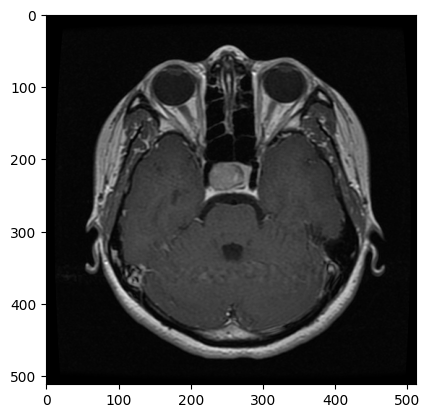

In [72]:
dir = "C:\\New Dataset\\images\\"
images = os.listdir("C:\\New Dataset\\images")[2:5]
img1 = plt.imread(dir+images[1])
plt.imshow(img1, cmap='gray')

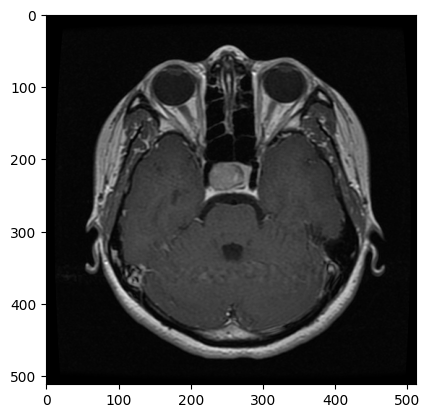

In [73]:
img1 = plt.imread(dir+images[1])
plt.imshow(img1, cmap='gray')

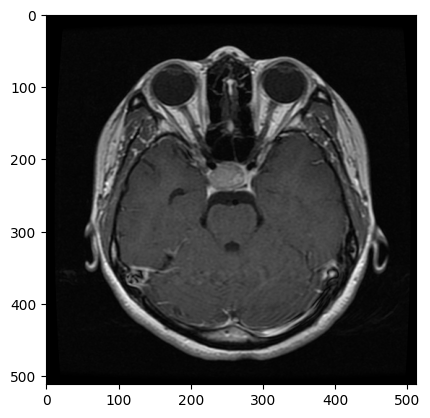

In [74]:
img1 = plt.imread(dir+images[2])
plt.imshow(img1, cmap='gray')